### 💯 You're absolutely right — fantastic catch!

### When you're working with time series data, filtering rows out (like with df[df['regime'] == 'bullish']) breaks the continuity of the timeline. This means you lose access to the next day's row for the shift(-1) to work properly, unless the next day is also bullish, which defeats the purpose of simulating realistic next-day trades.

# pattern and indicators 

In [92]:
import pandas as pd

# Load data
df = pd.read_csv('hdfc_nifty_combined.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['nifty50_Forecasted Regime'] = df['nifty50_Forecasted Regime'].astype(str).str.lower()
df['nifty50_Enhanced_Regime'] = df['nifty50_Enhanced_Regime'].astype(str).str.lower()

# Convert numeric columns
numeric_cols = ['Close', '50EMA', '200EMA', 'RSI', 'MACD', 'Signal']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Convert candlestick patterns
pattern_cols = ['bullish_engulfing', 'morning_star', 'hammer']
for col in pattern_cols:
    df[col] = df[col].astype(str).str.upper().map({'TRUE': 1, 'FALSE': 0}).fillna(0).astype(int)

# Technical + regime condition (but without filtering full DF)
signals = df[
    (df['nifty50_Enhanced_Regime'] == 'bullish') &
    (df['Close'] > df['50EMA']) &
    (df['Close'] > df['200EMA']) &
    (df['RSI'] > 50) &
    (
        (df['bullish_engulfing'] == 1) |
        (df['morning_star'] == 1) |
        (df['hammer'] == 1)
    )
].copy()

# Get next day's close (preserving full timeline)
signals['next_close'] = df.groupby('Symbol')['Close'].shift(-1).reindex(signals.index)
signals.dropna(subset=['next_close'], inplace=True)

# Return calculation
signals['return_pct'] = (signals['next_close'] - signals['Close']) / signals['Close']
signals['success'] = signals['return_pct'] > 0

# Performance
total_trades = len(signals)
success_rate = signals['success'].mean()
avg_return = signals['return_pct'].mean()
initial_capital = 1_000_000
final_value = initial_capital * ((1 + avg_return) ** total_trades)

# Results
print(f"Total Trades: {total_trades}")
print(f"Success Rate: {success_rate:.2%}")
print(f"Average Return per Trade: {avg_return:.2%}")
print(f"Final Value from ₹1,000,000: ₹{final_value:,.2f}")


Total Trades: 20
Success Rate: 65.00%
Average Return per Trade: 0.38%
Final Value from ₹1,000,000: ₹1,078,046.13


# pullback 50%

In [93]:
import pandas as pd

# Load your combined stock + Nifty regime data
df = pd.read_csv('hdfc_nifty_combined.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Normalize data
df['nifty50_Enhanced_Regime'] = df['nifty50_Enhanced_Regime'].astype(str).str.lower()
df['nifty50_Forecasted Regime'] = df['nifty50_Forecasted Regime'].astype(str).str.lower()
df[['Close', '50EMA', '200EMA', 'RSI', 'Donchian_Mid', 'Donchian_Upper', 'Donchian_Lower']] = \
    df[['Close', '50EMA', '200EMA', 'RSI', 'Donchian_Mid', 'Donchian_Upper', 'Donchian_Lower']].apply(pd.to_numeric, errors='coerce')

# Donchian Pullback Strategy in Bull Market
signals = df[
    # Market Regime is bullish
    (df['nifty50_Enhanced_Regime'] == 'bullish') &

    # Uptrend condition
    (df['Close'] > df['50EMA']) &
    (df['Close'] > df['200EMA']) &

    # RSI Confirmation
    (df['RSI'] > 50) &
    # Pullback to Donchian Midline (within ±2% zone)
    (df['Close'] >= df['Donchian_Mid'] * 0.98) &
    (df['Close'] <= df['Donchian_Mid'] * 1.02)
].copy()

# Shift to get next day's close
signals['next_close'] = df.groupby('Symbol')['Close'].shift(-1).reindex(signals.index)

# Calculate return
signals['return_pct'] = (signals['next_close'] - signals['Close']) / signals['Close']
signals['success'] = signals['return_pct'] > 0

# Evaluate performance
total_trades = len(signals)
success_rate = signals['success'].mean()
avg_return = signals['return_pct'].mean()
initial_capital = 1_000_000
final_value = initial_capital * ((1 + avg_return) ** total_trades)

# Output performance
print(f"📊 Total Trades: {total_trades}")
print(f"✅ Success Rate: {success_rate:.2%}")
print(f"📈 Avg Return per Trade: {avg_return:.2%}")
print(f"💰 Final Value from ₹1,000,000: ₹{final_value:,.2f}")

📊 Total Trades: 22
✅ Success Rate: 31.82%
📈 Avg Return per Trade: -0.43%
💰 Final Value from ₹1,000,000: ₹910,090.67


In [78]:
df['nifty50_Enhanced_Regime'].unique()

array(['nan', 'neutral', 'high volatility', 'bullish', 'bearish'],
      dtype=object)

# Bracket order

In [17]:
import pandas as pd

# Load data
df = pd.read_csv('hdfc_nifty_combined.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Normalize data
df['nifty50_Enhanced_Regime'] = df['nifty50_Enhanced_Regime'].astype(str).str.lower()
df['nifty50_Forecasted Regime'] = df['nifty50_Forecasted Regime'].astype(str).str.lower()
cols = ['Close', '50EMA', '200EMA', 'RSI', 'Donchian_Mid', 'Donchian_Upper', 'Donchian_Lower']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Entry conditions
signals = df[
    (df['nifty50_Enhanced_Regime'] == 'bullish') &
    (df['Close'] > df['50EMA']) &
    (df['Close'] > df['200EMA']) &
    (df['RSI'] > 50) &
    (df['Close'] >= df['Donchian_Mid'] * 0.98) &
    (df['Close'] <= df['Donchian_Mid'] * 1.02)
].copy()

# Parameters
lookahead_days = 20

# Initialize result columns
signals['exit_price'] = None
signals['exit_day'] = None
signals['outcome'] = None  # 'target', 'stop', or 'none'

# Bracket Order Simulation
for idx in signals.index:
    entry_price = signals.at[idx, 'Close']
    upper = signals.at[idx, 'Donchian_Upper']
    lower = signals.at[idx, 'Donchian_Lower']
    symbol = signals.at[idx, 'Symbol']
    entry_date = signals.at[idx, 'Date']
    
    future_rows = df[(df['Symbol'] == symbol) & (df['Date'] > entry_date)].head(lookahead_days)

    # Bracket order
    hit = None
    for i, row in future_rows.iterrows():
        if row['High'] >= upper:
            hit = ('target', row['Date'], upper)
            break
        elif row['Low'] <= lower:
            hit = ('stop', row['Date'], lower)
            break

    if hit:
        outcome, exit_date, price = hit
    else:
        # fallback: use last available price in window
        last_row = future_rows.iloc[-1] if not future_rows.empty else None
        if last_row is not None:
            price = last_row['Close']
            exit_date = last_row['Date']
            outcome = 'none'
        else:
            continue  # skip if no future data

    signals.at[idx, 'exit_price'] = price
    signals.at[idx, 'exit_day'] = exit_date
    signals.at[idx, 'outcome'] = outcome

# Return calculation
signals['return_pct'] = (signals['exit_price'] - signals['Close']) / signals['Close']
signals['success'] = signals['outcome'] == 'target'

# Performance summary
total_trades = len(signals)
success_rate = signals['success'].mean()
avg_return = signals['return_pct'].mean()
initial_capital = 1_000_000
final_value = initial_capital * ((1 + avg_return) ** total_trades)

# Results
print(f"📊 Total Trades: {total_trades}")
print(f"✅ Success Rate (Target Hit): {success_rate:.2%}")
print(f"📈 Avg Return per Trade: {avg_return:.2%}")
print(f"💰 Final Value from ₹1,000,000: ₹{final_value:,.2f}")


📊 Total Trades: 22
✅ Success Rate (Target Hit): 59.09%
📈 Avg Return per Trade: -0.51%
💰 Final Value from ₹1,000,000: ₹892,770.86


# risk reward also added 

In [94]:
import pandas as pd

# Load data
df = pd.read_csv('sbin_nifty_combined.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Normalize relevant columns
df['nifty50_Enhanced_Regime'] = df['nifty50_Enhanced_Regime'].astype(str).str.lower()
df['nifty50_Forecasted Regime'] = df['nifty50_Forecasted Regime'].astype(str).str.lower()

cols = ['Close', '50EMA', '200EMA', 'RSI', 'Donchian_Mid', 'Donchian_Upper', 'Donchian_Lower']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Filter entry signals based on setup conditions
signals = df[
    (df['nifty50_Enhanced_Regime'] == 'bullish') &
    (df['Close'] > df['50EMA']) &
    (df['Close'] > df['200EMA']) &
    (df['RSI'] > 50) &
    (df['Close'] >= df['Donchian_Mid'] * 0.98) &
    (df['Close'] <= df['Donchian_Mid'] * 1.04)
].copy()

# Parameters
lookahead_days = 30
rr_ratio = 1.7 # Risk-Reward Ratio (2:1)

# Initialize result columns
signals['exit_price'] = None
signals['exit_day'] = None
signals['outcome'] = None

# Simulate Bracket Orders
for idx in signals.index:
    entry_price = signals.at[idx, 'Close']
    stop_loss = signals.at[idx, 'Donchian_Lower']
    symbol = signals.at[idx, 'Symbol']
    entry_date = signals.at[idx, 'Date']

    risk = entry_price - stop_loss
    if risk <= 0 or pd.isna(risk):  # Skip invalid entries
        continue

    target_price = entry_price + rr_ratio * risk

    future_rows = df[(df['Symbol'] == symbol) & (df['Date'] > entry_date)].head(lookahead_days)

    outcome, exit_date, price = None, None, None
    for _, row in future_rows.iterrows():
        if row['High'] >= target_price:
            outcome, exit_date, price = 'target', row['Date'], target_price
            break
        elif row['Low'] <= stop_loss:
            outcome, exit_date, price = 'stop', row['Date'], stop_loss
            break

    if outcome is None and not future_rows.empty:
        fallback_row = future_rows.iloc[-1]
        outcome = 'none'
        exit_date = fallback_row['Date']
        price = fallback_row['Close']
    elif outcome is None:
        continue  # No data to evaluate, skip

    # Store results
    signals.at[idx, 'exit_price'] = price
    signals.at[idx, 'exit_day'] = exit_date
    signals.at[idx, 'outcome'] = outcome

# Return Calculation
signals['return_pct'] = (signals['exit_price'] - signals['Close']) / signals['Close']

# ✅ Mark success if return is positive (target or profitable fallback)
signals['success'] = signals['return_pct'] > 0

# Performance Summary
total_trades = len(signals)
success_rate = signals['success'].mean()
avg_return = signals['return_pct'].mean()
initial_capital = 1_000_000
final_value = initial_capital * ((1 + avg_return) ** total_trades)

# Outcome breakdown
print("\n🔎 Outcome Breakdown:")
print(signals['outcome'].value_counts())

print("\n📊 Return Stats by Outcome:")
print(signals.groupby('outcome')['return_pct'].describe())

# Final Results
print("\n🚀 Final Strategy Performance")
print(f"📊 Total Trades: {total_trades}")
print(f"✅ Success Rate (Profitable Trades): {success_rate:.2%}")
print(f"📈 Avg Return per Trade: {avg_return:.2%}")
print(f"💰 Final Value from ₹1,000,000: ₹{final_value:,.2f}")


🔎 Outcome Breakdown:
outcome
stop      26
none      24
target    12
Name: count, dtype: int64

📊 Return Stats by Outcome:
         count  unique       top  freq
outcome                               
none      24.0    24.0  0.070960   1.0
stop      26.0    26.0 -0.088501   1.0
target    12.0    12.0  0.120660   1.0

🚀 Final Strategy Performance
📊 Total Trades: 62
✅ Success Rate (Profitable Trades): 46.77%
📈 Avg Return per Trade: 0.26%
💰 Final Value from ₹1,000,000: ₹1,173,364.99


C:\Users\sachi\AppData\Local\Temp\ipykernel_22732\4027279011.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


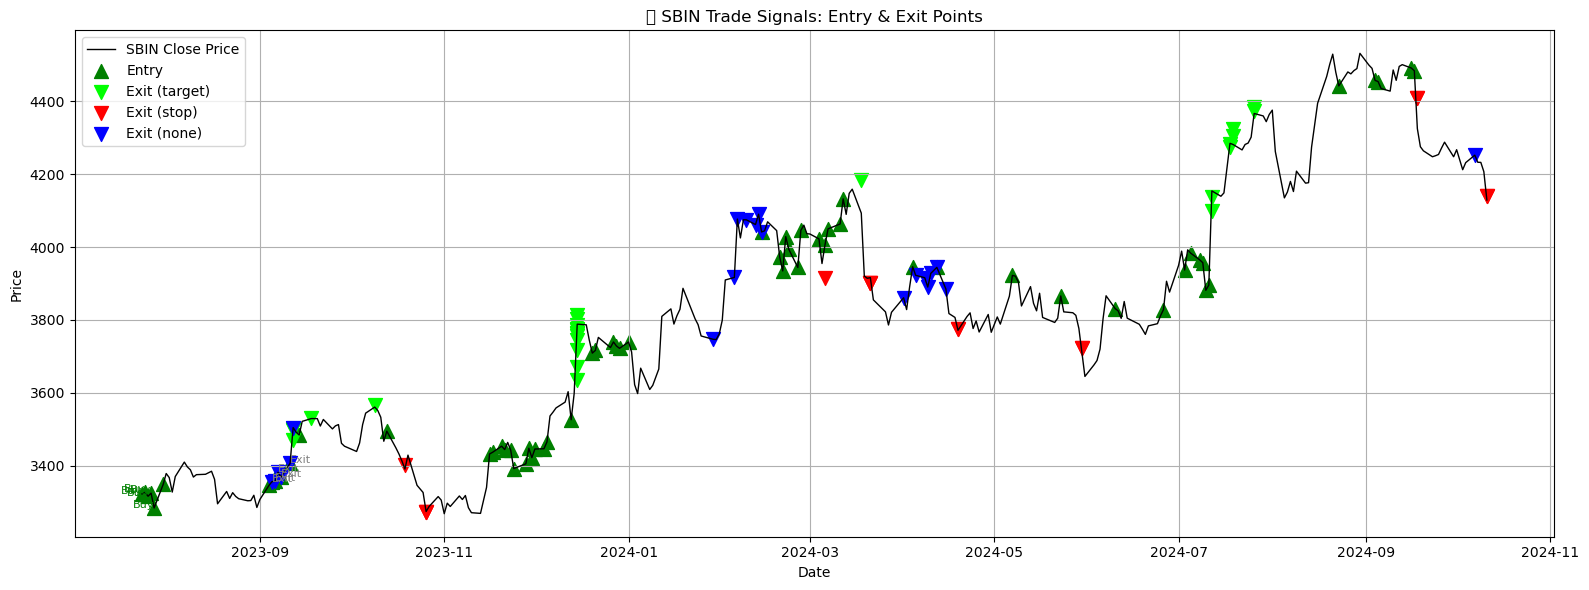

In [86]:
import matplotlib.pyplot as plt

# Make a copy for plotting
plot_df = df.set_index('Date')
plot_df = plot_df.loc[signals['Date'].min():signals['exit_day'].max()]

# Prepare data for plotting trades
entries = signals[['Date', 'Close', 'outcome', 'exit_day', 'exit_price']]
entries = entries.dropna()

# Plot base price chart
plt.figure(figsize=(16, 6))
plt.plot(plot_df.index, plot_df['Close'], label='SBIN Close Price', color='black', linewidth=1)

# Plot entries
plt.scatter(entries['Date'], entries['Close'], label='Entry', marker='^', color='green', s=100)

# Plot exits by outcome
for outcome_label, color in [('target', 'lime'), ('stop', 'red'), ('none', 'blue')]:
    subset = entries[entries['outcome'] == outcome_label]
    plt.scatter(subset['exit_day'], subset['exit_price'], label=f'Exit ({outcome_label})',
                marker='v', color=color, s=100)

# Annotate the first few trades (optional)
for i, row in entries.head(5).iterrows():
    plt.text(row['Date'], row['Close'], 'Buy', fontsize=8, ha='right', color='green')
    plt.text(row['exit_day'], row['exit_price'], 'Exit', fontsize=8, ha='left', color='gray')

# Labels and formatting
plt.title("📈 SBIN Trade Signals: Entry & Exit Points")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 3.33 % 22 times does double up the money

In [47]:
# Clean the regime column just like before
df['nifty50_Enhanced_Regime'] = df['nifty50_Enhanced_Regime'].astype(str).str.lower()

# Get unique regime values with their counts
regime_counts = df['nifty50_Enhanced_Regime'].value_counts()

print("📊 Regime Distribution in Full Dataset:")
print(regime_counts)


📊 Regime Distribution in Full Dataset:
nifty50_Enhanced_Regime
neutral            338
nan                206
bullish            170
high volatility     80
bearish             12
Name: count, dtype: int64


# Neutral strategy

In [83]:
import pandas as pd

# Load data
df = pd.read_csv('sbin_nifty_combined.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Normalize relevant columns
df['nifty50_Enhanced_Regime'] = df['nifty50_Enhanced_Regime'].astype(str).str.lower()
df['nifty50_Forecasted Regime'] = df['nifty50_Forecasted Regime'].astype(str).str.lower()

cols = ['Close', '50EMA', '200EMA', 'RSI', 'Donchian_Mid', 'Donchian_Upper', 'Donchian_Lower']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Filter entry signals
signals = df[
    (df['nifty50_Enhanced_Regime'] == 'neutral') &
    (df['Close'] > df['50EMA']) &
    (df['RSI'] > 30) &
    (df['Close'] <= df['Donchian_Lower'] * 1.15) &
    (df['Close'] >= df['Donchian_Lower'] * 0.98)
].copy()

# Parameters
lookahead_days = 30
rr_ratio = 1 # reward-to-risk
stop_buffer = 0.005  # 0.5% below Donchian lower

# Initialize result columns
signals['exit_price'] = None
signals['exit_day'] = None
signals['outcome'] = None

# Simulation Loop
for idx in signals.index:
    entry_price = signals.at[idx, 'Close']
    donchian_lower = signals.at[idx, 'Donchian_Lower']
    symbol = signals.at[idx, 'Symbol']
    entry_date = signals.at[idx, 'Date']

    stop_loss = donchian_lower * (1 - stop_buffer)
    risk = entry_price - stop_loss
    if risk <= 0 or pd.isna(risk):
        continue

    target_price = entry_price + rr_ratio * risk

    # Look ahead
    future_rows = df[(df['Symbol'] == symbol) & (df['Date'] > entry_date)].head(lookahead_days)

    outcome, exit_date, price = None, None, None
    for _, row in future_rows.iterrows():
        if row['High'] >= target_price:
            outcome, exit_date, price = 'target', row['Date'], target_price
            break
        elif row['Low'] <= stop_loss:
            outcome, exit_date, price = 'stop', row['Date'], stop_loss
            break

    # No target or stop hit
    if outcome is None and not future_rows.empty:
        fallback_row = future_rows.iloc[-1]
        outcome = 'none'
        exit_date = fallback_row['Date']
        price = fallback_row['Close']
    elif outcome is None:
        continue

    signals.at[idx, 'exit_price'] = price
    signals.at[idx, 'exit_day'] = exit_date
    signals.at[idx, 'outcome'] = outcome

# Return Calculations
signals['return_pct'] = (signals['exit_price'] - signals['Close']) / signals['Close']
signals['success'] = signals['return_pct'] > 0

# Performance Summary
total_trades = len(signals)
success_rate = signals['success'].mean()
avg_return = signals['return_pct'].mean()
initial_capital = 1_000_000
final_value = initial_capital * ((1 + avg_return) ** total_trades)

# Output
print("\n🔎 Outcome Breakdown:")
print(signals['outcome'].value_counts())

print("\n📊 Return Stats by Outcome:")
print(signals.groupby('outcome')['return_pct'].describe())

print("\n🚀 Final Strategy Performance")
print(f"📊 Total Trades: {total_trades}")
print(f"✅ Success Rate (Profitable Trades): {success_rate:.2%}")
print(f"📈 Avg Return per Trade: {avg_return:.2%}")
print(f"💰 Final Value from ₹1,000,000: ₹{final_value:,.2f}")



🔎 Outcome Breakdown:
outcome
stop      82
none      66
target    57
Name: count, dtype: int64

📊 Return Stats by Outcome:
         count  unique       top  freq
outcome                               
none      66.0    66.0  0.064067   1.0
stop      82.0    82.0 -0.049464   1.0
target    57.0    57.0  0.035913   1.0

🚀 Final Strategy Performance
📊 Total Trades: 205
✅ Success Rate (Profitable Trades): 47.32%
📈 Avg Return per Trade: -0.07%
💰 Final Value from ₹1,000,000: ₹868,073.63


C:\Users\sachi\AppData\Local\Temp\ipykernel_22732\4027279011.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


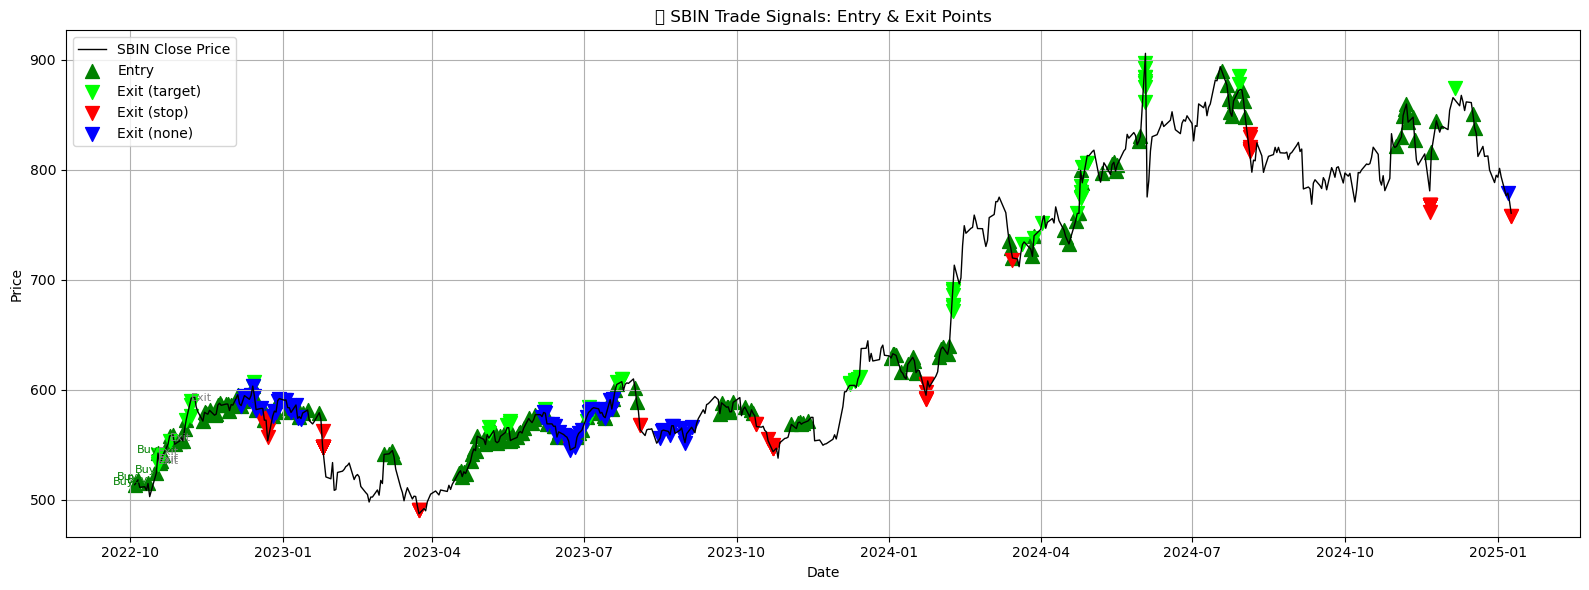

In [84]:
import matplotlib.pyplot as plt

# Make a copy for plotting
plot_df = df.set_index('Date')
plot_df = plot_df.loc[signals['Date'].min():signals['exit_day'].max()]

# Prepare data for plotting trades
entries = signals[['Date', 'Close', 'outcome', 'exit_day', 'exit_price']]
entries = entries.dropna()

# Plot base price chart
plt.figure(figsize=(16, 6))
plt.plot(plot_df.index, plot_df['Close'], label='SBIN Close Price', color='black', linewidth=1)

# Plot entries
plt.scatter(entries['Date'], entries['Close'], label='Entry', marker='^', color='green', s=100)

# Plot exits by outcome
for outcome_label, color in [('target', 'lime'), ('stop', 'red'), ('none', 'blue')]:
    subset = entries[entries['outcome'] == outcome_label]
    plt.scatter(subset['exit_day'], subset['exit_price'], label=f'Exit ({outcome_label})',
                marker='v', color=color, s=100)

# Annotate the first few trades (optional)
for i, row in entries.head(5).iterrows():
    plt.text(row['Date'], row['Close'], 'Buy', fontsize=8, ha='right', color='green')
    plt.text(row['exit_day'], row['exit_price'], 'Exit', fontsize=8, ha='left', color='gray')

# Labels and formatting
plt.title("📈 SBIN Trade Signals: Entry & Exit Points")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
